
# Tutorial on learning to generate sine waves with e-prop

Training a regression model using supervised e-prop plasticity to generate sine waves.

This is a reduced version compatible with NEST 3.8 of the example available at https://nest-simulator.readthedocs.io/en/stable/auto_examples/eprop_plasticity/eprop_supervised_regression_sine-waves.html. This version does not yet use the enhanced biological realism.

## Description

This script demonstrates supervised learning of a regression task with a recurrent spiking neural network that is equipped with the eligibility propagation (e-prop) plasticity mechanism by Bellec et al. [1]. For details of the NEST implementation, see [2]. Some choices in this script were made to allow exact reproduction of [the original results by Bellec et al](https://github.com/IGITUGraz/eligibility_propagation/blob/master/Figure_3_and_S7_e_prop_tutorials/tutorial_pattern_generation.py) and are not recommended for new projects.

The network learns to reproduce with its overall spiking activity a one-dimensional, one-second-long target signal which is a superposition of four sine waves of different amplitudes, phases, and periods.

![eprop_supervised_regression_sine-waves.png](eprop_supervised_regression_sine-waves.png)

- Learning in the neural network model is achieved by optimizing the connection weights with e-prop plasticity.
- The neural network model consists of a recurrent network that receives frozen noise input from Poisson generators and projects onto one
readout neuron.
- The readout neuron compares the network signal $y$ with the teacher target signal
$y*$, which it receives from a rate generator.

### References

- [1] Bellec G, Scherr F, Subramoney F, Hajek E, Salaj D, Legenstein R, Maass W (2020). A solution to the
       learning dilemma for recurrent networks of spiking neurons. Nature Communications, 11:3625.
       https://doi.org/10.1038/s41467-020-17236-y
- [2] Korcsak-Gorzo A, Stapmanns J, Espinoza Valverde JA, Dahmen D, van Albada SJ, Bolten M, Diesmann M.
       Event-driven eligibility propagation in large sparse networks: efficiency shaped by biological realism. arXiv http://arxiv.org/abs/2511.21674

## Import libraries
We begin by importing all libraries required for the simulation, analysis, and visualization.



In [28]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import nest
import numpy as np
from cycler import cycler
from IPython.display import Image

## Setup



### Initialize random generator

Seed the numpy random generator, which will generate random initial weights as well as random input and
output.

**Note:** This is for compatibility with the work of Bellec et al. One should use NEST's built-in randomization to initialize the weights.

In [29]:
rng_seed = 1  # numpy random seed
np.random.seed(rng_seed)  # fix numpy random seed

### Define timing of task

In [82]:
n_batch = 1  # batch size
n_iter = 500   # number of iterations, kept small here to limit runtime, use 2000 for production

steps = {
    "sequence": 1000,  # time steps of one full sequence
}

steps["learning_window"] = steps["sequence"]  # time steps of window with non-zero learning signals
steps["task"] = n_iter * n_batch * steps["sequence"]  # time steps of task

steps.update(
    {
        "offset_gen": 1,  # offset since generator signals start from time step 1
        "delay_in_rec": 1,  # connection delay between input and recurrent neurons
        "delay_rec_out": 1,  # connection delay between recurrent and output neurons
        "delay_out_norm": 1,  # connection delay between output neurons for normalization
        "extension_sim": 1,  # extra time step to close right-open simulation time interval in Simulate()
    }
)

steps["delays"] = steps["delay_in_rec"] + steps["delay_rec_out"] + steps["delay_out_norm"]  # time steps of delays

steps["total_offset"] = steps["offset_gen"] + steps["delays"]  # time steps of total offset

steps["sim"] = steps["task"] + steps["total_offset"] + steps["extension_sim"]  # time steps of simulation

duration = {"step": 1.0}  # ms, temporal resolution of the simulation

duration.update({key: value * duration["step"] for key, value in steps.items()})  # ms, durations

### Set up simulation
As last step of the setup, we reset the NEST kernel to remove all existing NEST simulation settings and
objects and set some NEST kernel parameters, some of which are e-prop-related.



In [83]:
params_setup = {
    "eprop_learning_window": duration["learning_window"],
    "eprop_reset_neurons_on_update": True,  # if True, reset dynamic variables at start of each update interval
    "eprop_update_interval": duration["sequence"],  # ms, time interval for updating the synaptic weights
    "print_time": False,  # if True, print time progress bar during simulation, set False if run as code cell
    "resolution": duration["step"],
    "total_num_virtual_procs": 4,  # number of virtual processes, set in case of distributed computing
}

In [84]:
nest.ResetKernel()
nest.set(**params_setup)


Jan 13 14:29:34 correlation_detector [Info]: 
    Default for delta_tau changed from 0.5 to 5 ms

Jan 13 14:29:34 correlomatrix_detector [Info]: 
    Default for delta_tau changed from 0.5 to 5 ms

Jan 13 14:29:34 correlospinmatrix_detector [Info]: 
    Default for delta_tau changed from 0.1 to 1 ms

Jan 13 14:29:34 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 1 ms.


## Create neurons
We proceed by creating a certain number of input, recurrent, and readout neurons and setting their parameters.
Additionally, we already create an input spike generator and an output target rate generator, which we will
configure later.



In [85]:
n_in = 100  # number of input neurons
n_rec = 100  # number of recurrent neurons
n_out = 1  # number of readout neurons

params_nrn_rec = {
    "C_m": 1.0,  # pF, membrane capacitance - takes effect only if neurons get current input (here not the case)
    "c_reg": 300.0,  # firing rate regularization scaling
    "E_L": 0.0,  # mV, leak / resting membrane potential
    "f_target": 10.0,  # spikes/s, target firing rate for firing rate regularization
    "gamma": 0.3,  # scaling of the pseudo derivative
    "I_e": 0.0,  # pA, external current input
    "regular_spike_arrival": False,  # If True, input spikes arrive at end of time step, if False at beginning
    "surrogate_gradient_function": "piecewise_linear",  # surrogate gradient / pseudo-derivative function
    "t_ref": 0.0,  # ms, duration of refractory period
    "tau_m": 30.0,  # ms, membrane time constant
    "V_m": 0.0,  # mV, initial value of the membrane voltage
    "V_th": 0.03,  # mV, spike threshold membrane voltage
}

params_nrn_out = {
    "C_m": 1.0,
    "E_L": 0.0,
    "I_e": 0.0,
    "loss": "mean_squared_error",  # loss function
    "regular_spike_arrival": False,
    "tau_m": 30.0,
    "V_m": 0.0,
}

In [86]:
# Intermediate parrot neurons required between input spike generators and recurrent neurons,
# since devices cannot establish plastic synapses for technical reasons

gen_spk_in = nest.Create("spike_generator", n_in)
nrns_in = nest.Create("parrot_neuron", n_in)

# The suffix _bsshslm_2020 follows the NEST convention to indicate in the model name the paper
# that introduced it by the first letter of the authors' last names and the publication year.

nrns_rec = nest.Create("eprop_iaf_bsshslm_2020", n_rec, params_nrn_rec)
nrns_out = nest.Create("eprop_readout_bsshslm_2020", n_out, params_nrn_out)
gen_rate_target = nest.Create("step_rate_generator", n_out)

## Create recorders
We also create recorders, which, while not required for the training, will allow us to track various dynamic
variables of the neurons, spikes, and changes in synaptic weights.

In [87]:
n_record = 1  # number of neurons to record dynamic variables from - this script requires n_record >= 1
n_record_w = 3  # number of senders and targets to record weights from - this script requires n_record_w >=1

if n_record == 0 or n_record_w == 0:
    raise ValueError("n_record and n_record_w >= 1 required")

params_mm_rec = {
    "interval": duration["step"],  # interval between two recorded time points
    "record_from": ["V_m", "surrogate_gradient", "learning_signal"],  # dynamic variables to record
    "start": duration["offset_gen"] + duration["delay_in_rec"],  # start time of recording
    "stop": duration["offset_gen"] + duration["delay_in_rec"] + duration["task"],  # stop time of recording
}

params_mm_out = {
    "interval": duration["step"],
    "record_from": ["V_m", "readout_signal", "readout_signal_unnorm", "target_signal", "error_signal"],
    "start": duration["total_offset"],
    "stop": duration["total_offset"] + duration["task"],
}

params_wr = {
    "senders": nrns_in[:n_record_w] + nrns_rec[:n_record_w],  # limit senders to subsample weights to record
    "targets": nrns_rec[:n_record_w] + nrns_out,  # limit targets to subsample weights to record from
    "start": duration["total_offset"],
    "stop": duration["total_offset"] + duration["task"],
}

params_sr = {
    "start": duration["total_offset"],
    "stop": duration["total_offset"] + duration["task"],
}

In [88]:
mm_rec = nest.Create("multimeter", params_mm_rec)
mm_out = nest.Create("multimeter", params_mm_out)
sr = nest.Create("spike_recorder", params_sr)
wr = nest.Create("weight_recorder", params_wr)

nrns_rec_record = nrns_rec[:n_record]

## Create connections
Now, we define the connectivity and set up the synaptic parameters, with the synaptic weights drawn from
normal distributions. After these preparations, we establish the enumerated connections of the core network,
as well as additional connections to the recorders.

**Note:** Weights are randomized using NumPy using 32-bit floating point numbers to ensure precise reproduction of the results of Bellec et al. For new studies, use NEST's built-in randomization to determine weights.

In [89]:
params_conn_all_to_all = {"rule": "all_to_all", "allow_autapses": False}
params_conn_one_to_one = {"rule": "one_to_one"}

dtype_weights = np.float32  # data type of weights - for reproducing TF results set to np.float32
weights_in_rec = np.array(np.random.randn(n_in, n_rec).T / np.sqrt(n_in), dtype=dtype_weights)
weights_rec_rec = np.array(np.random.randn(n_rec, n_rec).T / np.sqrt(n_rec), dtype=dtype_weights)
np.fill_diagonal(weights_rec_rec, 0.0)  # since no autapses set corresponding weights to zero
weights_rec_out = np.array(np.random.randn(n_rec, n_out).T / np.sqrt(n_rec), dtype=dtype_weights)
weights_out_rec = np.array(np.random.randn(n_rec, n_out) / np.sqrt(n_rec), dtype=dtype_weights)

params_common_syn_eprop = {
    "optimizer": {
        "type": "gradient_descent",  # algorithm to optimize the weights
        "batch_size": n_batch,
        "eta": 1e-4,  # learning rate
        "Wmin": -100.0,  # pA, minimal limit of the synaptic weights
        "Wmax": 100.0,  # pA, maximal limit of the synaptic weights
    },
    "average_gradient": False,  # if True, average the gradient over the learning window
    "weight_recorder": wr,
}

params_syn_base = {
    "synapse_model": "eprop_synapse_bsshslm_2020",
    "delay": duration["step"],  # ms, dendritic delay
    "tau_m_readout": params_nrn_out["tau_m"],  # ms, for technical reasons pass readout neuron membrane time constant
}

params_syn_in = params_syn_base.copy()
params_syn_in["weight"] = weights_in_rec  # pA, initial values for the synaptic weights

params_syn_rec = params_syn_base.copy()
params_syn_rec["weight"] = weights_rec_rec

params_syn_out = params_syn_base.copy()
params_syn_out["weight"] = weights_rec_out

params_syn_feedback = {
    "synapse_model": "eprop_learning_signal_connection_bsshslm_2020",
    "delay": duration["step"],
    "weight": weights_out_rec,
}

params_syn_rate_target = {
    "synapse_model": "rate_connection_delayed",
    "delay": duration["step"],
    "receptor_type": 2,  # receptor type over which readout neuron receives target signal
}

params_syn_static = {
    "synapse_model": "static_synapse",
    "delay": duration["step"],
}

In [90]:
nest.SetDefaults("eprop_synapse_bsshslm_2020", params_common_syn_eprop)

nest.Connect(gen_spk_in, nrns_in, params_conn_one_to_one, params_syn_static)  # connection 1
nest.Connect(nrns_in, nrns_rec, params_conn_all_to_all, params_syn_in)  # connection 2
nest.Connect(nrns_rec, nrns_rec, params_conn_all_to_all, params_syn_rec)  # connection 3
nest.Connect(nrns_rec, nrns_out, params_conn_all_to_all, params_syn_out)  # connection 4
nest.Connect(nrns_out, nrns_rec, params_conn_all_to_all, params_syn_feedback)  # connection 5
nest.Connect(gen_rate_target, nrns_out, params_conn_one_to_one, params_syn_rate_target)  # connection 6

nest.Connect(nrns_in + nrns_rec, sr, params_conn_all_to_all, params_syn_static)

nest.Connect(mm_rec, nrns_rec_record, params_conn_all_to_all, params_syn_static)
nest.Connect(mm_out, nrns_out, params_conn_all_to_all, params_syn_static)

## Create input
We generate some frozen Poisson spike noise of a fixed rate that is repeated in each iteration and feed these
spike times to the previously created input spike generator. The network will use these spike times as a
temporal backbone for encoding the target signal into its recurrent spiking activity.



In [91]:
input_spike_prob = 0.05  # spike probability of frozen input noise
dtype_in_spks = np.float32  # data type of input spikes - for reproducing TF results set to np.float32

input_spike_bools = (np.random.rand(steps["sequence"], n_in) < input_spike_prob).swapaxes(0, 1)
input_spike_bools[:, 0] = 0  # remove spikes in 0th time step of every sequence for technical reasons

sequence_starts = np.arange(0.0, duration["task"], duration["sequence"]) + duration["offset_gen"]
params_gen_spk_in = []
for input_spike_bool in input_spike_bools:
    input_spike_times = np.arange(0.0, duration["sequence"], duration["step"])[input_spike_bool]
    input_spike_times_all = [input_spike_times + start for start in sequence_starts]
    params_gen_spk_in.append({"spike_times": np.hstack(input_spike_times_all).astype(dtype_in_spks)})

In [92]:
nest.SetStatus(gen_spk_in, params_gen_spk_in)

## Create output
Then, as a superposition of four sine waves with various durations, amplitudes, and phases, we construct a
one-second target signal. This signal, like the input, is repeated for all iterations and fed into the rate
generator that was previously created.



In [93]:
def generate_superimposed_sines(steps_sequence, periods):
    n_sines = len(periods)

    amplitudes = np.random.uniform(low=0.5, high=2.0, size=n_sines)
    phases = np.random.uniform(low=0.0, high=2.0 * np.pi, size=n_sines)

    sines = [
        A * np.sin(np.linspace(phi, phi + 2.0 * np.pi * (steps_sequence // T), steps_sequence))
        for A, phi, T in zip(amplitudes, phases, periods)
    ]

    superposition = sum(sines)
    superposition -= superposition[0]
    superposition /= max(np.abs(superposition).max(), 1e-6)
    return superposition


target_signal = generate_superimposed_sines(steps["sequence"], [1000, 500, 333, 200])  # periods in steps

params_gen_rate_target = {
    "amplitude_times": np.arange(0.0, duration["task"], duration["step"]) + duration["total_offset"],
    "amplitude_values": np.tile(target_signal, n_iter * n_batch),
}

In [94]:
nest.SetStatus(gen_rate_target, params_gen_rate_target)

## Force final update
Synapses only get active, that is, the correct weight update calculated and applied, when they transmit a
spike. To still be able to read out the correct weights at the end of the simulation, we force spiking of the
presynaptic neuron and thus an update of all synapses, including those that have not transmitted a spike in
the last update interval, by sending a strong spike to all neurons that form the presynaptic side of an eprop
synapse. This step is required purely for technical reasons.



In [95]:
gen_spk_final_update = nest.Create("spike_generator", 1, {"spike_times": [duration["task"] + duration["delays"]]})

nest.Connect(gen_spk_final_update, nrns_in + nrns_rec, "all_to_all", {"weight": 1000.0})

## Read out pre-training weights
Before we begin training, we read out the initial weight matrices so that we can eventually compare them to
the optimized weights.



In [96]:
def get_weights(pop_pre, pop_post):
    conns = nest.GetConnections(pop_pre, pop_post).get(["source", "target", "weight"])
    conns["senders"] = np.array(conns["source"]) - np.min(conns["source"])
    conns["targets"] = np.array(conns["target"]) - np.min(conns["target"])

    conns["weight_matrix"] = np.zeros((len(pop_post), len(pop_pre)))
    conns["weight_matrix"][conns["targets"], conns["senders"]] = conns["weight"]
    return conns


weights_pre_train = {
    "in_rec": get_weights(nrns_in, nrns_rec),
    "rec_rec": get_weights(nrns_rec, nrns_rec),
    "rec_out": get_weights(nrns_rec, nrns_out),
}

## Simulate
We train the network by simulating for a set simulation time, determined by the number of iterations and the
batch size and the length of one sequence.



In [97]:
nest.Simulate(duration["sim"])


Jan 13 14:29:42 NodeManager::prepare_nodes [Info]: 
    Preparing 625 nodes for simulation.

Jan 13 14:29:42 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 625
    Simulation time (ms): 500005
    Number of OpenMP threads: 4
    Not using MPI

Jan 13 14:30:03 SimulationManager::run [Info]: 
    Simulation finished.


## Read out post-training weights
After the training, we can read out the optimized final weights.



In [98]:
weights_post_train = {
    "in_rec": get_weights(nrns_in, nrns_rec),
    "rec_rec": get_weights(nrns_rec, nrns_rec),
    "rec_out": get_weights(nrns_rec, nrns_out),
}

## Read out recorders
We can also retrieve the recorded history of the dynamic variables and weights, as well as detected spikes.



In [99]:
events_mm_rec = mm_rec.get("events")
events_mm_out = mm_out.get("events")
events_sr = sr.get("events")
events_wr = wr.get("events")

## Evaluate training error
We evaluate the network's training error by calculating a loss - in this case, the mean squared error between
the integrated recurrent network activity and the target rate.



In [100]:
readout_signal = events_mm_out["readout_signal"]
target_signal = events_mm_out["target_signal"]

error = (readout_signal - target_signal) ** 2
loss = 0.5 * np.add.reduceat(error, np.arange(0, steps["task"], steps["sequence"]))

## Plot results
Then, we plot a series of plots.



In [101]:
do_plotting = True  # if True, plot the results

if not do_plotting:
    exit()

colors = {
    "blue": "#2854c5ff",
    "red": "#e04b40ff",
    "white": "#ffffffff",
}

plt.rcParams.update(
    {
        "font.sans-serif": "Arial",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "axes.prop_cycle": cycler(color=[colors["blue"], colors["red"]]),
    }
)

### Plot training error
We begin with a plot visualizing the training error of the network: the loss plotted against the iterations.



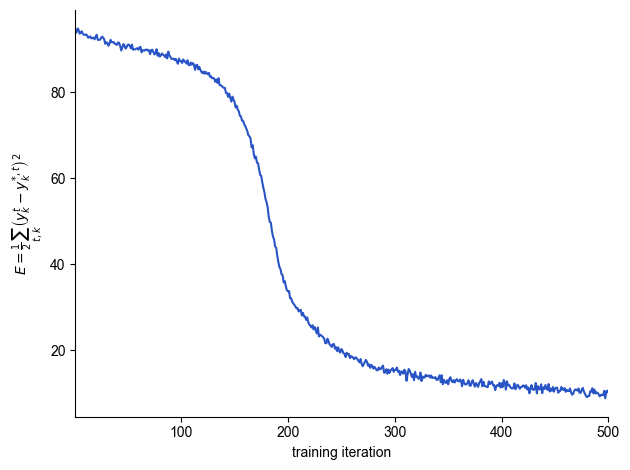

In [102]:
fig, ax = plt.subplots()

ax.plot(range(1, n_iter + 1), loss)
ax.set_ylabel(r"$E = \frac{1}{2} \sum_{t,k} \left( y_k^t -y_k^{*,t}\right)^2$")
ax.set_xlabel("training iteration")
ax.set_xlim(1, n_iter)
ax.xaxis.get_major_locator().set_params(integer=True)

fig.tight_layout()

### Plot spikes and dynamic variables
This plotting routine shows how to plot all of the recorded dynamic variables and spikes across time. We take
one snapshot in the first iteration and one snapshot at the end.



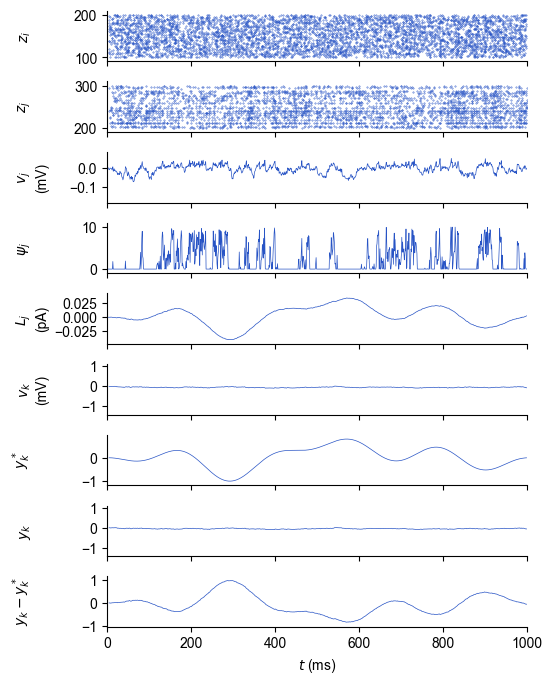

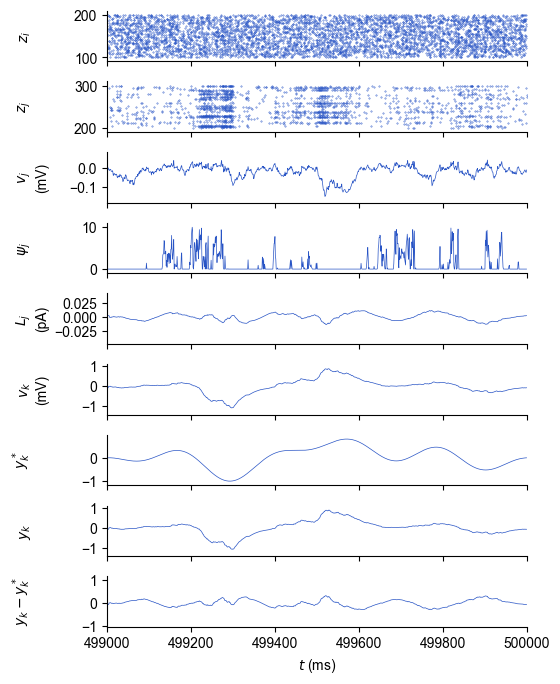

In [103]:
def plot_recordable(ax, events, recordable, ylabel, xlims):
    for sender in set(events["senders"]):
        idc_sender = events["senders"] == sender
        idc_times = (events["times"][idc_sender] > xlims[0]) & (events["times"][idc_sender] < xlims[1])
        ax.plot(events["times"][idc_sender][idc_times], events[recordable][idc_sender][idc_times], lw=0.5)
    ax.set_ylabel(ylabel)
    margin = np.abs(np.max(events[recordable]) - np.min(events[recordable])) * 0.1
    ax.set_ylim(np.min(events[recordable]) - margin, np.max(events[recordable]) + margin)


def plot_spikes(ax, events, nrns, ylabel, xlims):
    idc_times = (events["times"] > xlims[0]) & (events["times"] < xlims[1])
    idc_sender = np.isin(events["senders"][idc_times], nrns.tolist())
    senders_subset = events["senders"][idc_times][idc_sender]
    times_subset = events["times"][idc_times][idc_sender]

    ax.scatter(times_subset, senders_subset, s=0.1)
    ax.set_ylabel(ylabel)
    margin = np.abs(np.max(senders_subset) - np.min(senders_subset)) * 0.1
    ax.set_ylim(np.min(senders_subset) - margin, np.max(senders_subset) + margin)


for fn, xlims in enumerate([(0, steps["sequence"]), (steps["task"] - steps["sequence"], steps["task"])]):
    fig, axs = plt.subplots(9, 1, sharex=True, figsize=(6, 8), gridspec_kw={"hspace": 0.4, "left": 0.2})

    plot_spikes(axs[0], events_sr, nrns_in, r"$z_i$" + "\n", xlims)
    plot_spikes(axs[1], events_sr, nrns_rec, r"$z_j$" + "\n", xlims)

    plot_recordable(axs[2], events_mm_rec, "V_m", r"$v_j$" + "\n(mV)", xlims)
    plot_recordable(axs[3], events_mm_rec, "surrogate_gradient", r"$\psi_j$" + "\n", xlims)
    plot_recordable(axs[4], events_mm_rec, "learning_signal", r"$L_j$" + "\n(pA)", xlims)

    plot_recordable(axs[5], events_mm_out, "V_m", r"$v_k$" + "\n(mV)", xlims)
    plot_recordable(axs[6], events_mm_out, "target_signal", r"$y^*_k$" + "\n", xlims)
    plot_recordable(axs[7], events_mm_out, "readout_signal", r"$y_k$" + "\n", xlims)
    plot_recordable(axs[8], events_mm_out, "error_signal", r"$y_k-y^*_k$" + "\n", xlims)

    axs[-1].set_xlabel(r"$t$ (ms)")
    axs[-1].set_xlim(*xlims)

    fig.align_ylabels()

### Plot weight time courses
Similarly, we can plot the weight histories. Note that the weight recorder, attached to the synapses, works
differently than the other recorders. Since synapses only get activated when they transmit a spike, the weight
recorder only records the weight in those moments. That is why the first weight registrations do not start in
the first time step and we add the initial weights manually.



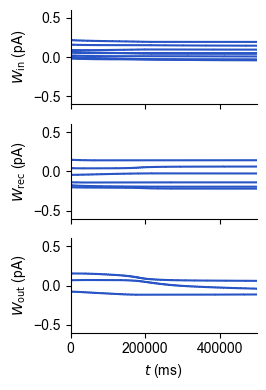

In [104]:
def plot_weight_time_course(ax, events, nrns_senders, nrns_targets, label, ylabel):
    for sender in nrns_senders.tolist():
        for target in nrns_targets.tolist():
            idc_syn = (events["senders"] == sender) & (events["targets"] == target)
            idc_syn_pre = (weights_pre_train[label]["source"] == sender) & (
                weights_pre_train[label]["target"] == target
            )

            times = [0.0] + events["times"][idc_syn].tolist()
            weights = [weights_pre_train[label]["weight"][idc_syn_pre]] + events["weights"][idc_syn].tolist()

            ax.step(times, weights, c=colors["blue"])
        ax.set_ylabel(ylabel)
        ax.set_ylim(-0.6, 0.6)


fig, axs = plt.subplots(3, 1, sharex=True, figsize=(3, 4))

plot_weight_time_course(axs[0], events_wr, nrns_in[:n_record_w], nrns_rec[:n_record_w], "in_rec", r"$W_\text{in}$ (pA)")
plot_weight_time_course(
    axs[1], events_wr, nrns_rec[:n_record_w], nrns_rec[:n_record_w], "rec_rec", r"$W_\text{rec}$ (pA)"
)
plot_weight_time_course(axs[2], events_wr, nrns_rec[:n_record_w], nrns_out, "rec_out", r"$W_\text{out}$ (pA)")

axs[-1].set_xlabel(r"$t$ (ms)")
axs[-1].set_xlim(0, steps["task"])

fig.align_ylabels()
fig.tight_layout()

### Plot weight matrices
If one is not interested in the time course of the weights, it is possible to read out only the initial and
final weights, which requires less computing time and memory than the weight recorder approach. Here, we plot
the corresponding weight matrices before and after the optimization.



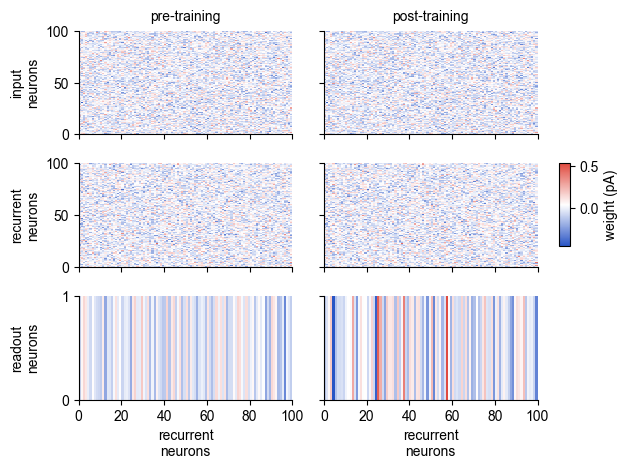

In [105]:
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    "cmap", ((0.0, colors["blue"]), (0.5, colors["white"]), (1.0, colors["red"]))
)

fig, axs = plt.subplots(3, 2, sharex="col", sharey="row")

all_w_extrema = []

for k in weights_pre_train.keys():
    w_pre = weights_pre_train[k]["weight"]
    w_post = weights_post_train[k]["weight"]
    all_w_extrema.append([np.min(w_pre), np.max(w_pre), np.min(w_post), np.max(w_post)])

args = {"cmap": cmap, "vmin": np.min(all_w_extrema), "vmax": np.max(all_w_extrema)}

for i, weights in zip([0, 1], [weights_pre_train, weights_post_train]):
    axs[0, i].pcolormesh(weights["in_rec"]["weight_matrix"].T, **args)
    axs[1, i].pcolormesh(weights["rec_rec"]["weight_matrix"], **args)
    cmesh = axs[2, i].pcolormesh(weights["rec_out"]["weight_matrix"], **args)

    axs[2, i].set_xlabel("recurrent\nneurons")

axs[0, 0].set_ylabel("input\nneurons")
axs[1, 0].set_ylabel("recurrent\nneurons")
axs[2, 0].set_ylabel("readout\nneurons")
fig.align_ylabels(axs[:, 0])

axs[0, 0].text(0.5, 1.1, "pre-training", transform=axs[0, 0].transAxes, ha="center")
axs[0, 1].text(0.5, 1.1, "post-training", transform=axs[0, 1].transAxes, ha="center")

axs[2, 0].yaxis.get_major_locator().set_params(integer=True)

cbar = plt.colorbar(cmesh, cax=axs[1, 1].inset_axes([1.1, 0.2, 0.05, 0.8]), label="weight (pA)")

fig.tight_layout()

plt.show()